
pip install -r requirements.txt
pip install pipwin
pipwin install -r requirements.txt

0=women
1=men
0=no pd
1=pd

In [73]:
## Initial Imports

%matplotlib inline

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold, train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report

**`Read data and Display data dimension`**

In [2]:
pd_speech_features_gender = pd.read_csv(r'C:\Users\Asus\Videos\pd paper selected data\gender_FG.csv')

pd_speech_features_gender.head()
print('The shape of the matrix is :', pd_speech_features_gender.shape)

The shape of the matrix is : (756, 72)


#### Gather most general metadata about the data

In [3]:

pd_speech_features_gender.groupby('class').sum()/3

,app_LT_entropy_shannon_3_coef,tqwt_entropy_log_dec_10,app_LT_TKEO_mean_7_coef,mean_MFCC_10th_coef,app_LT_TKEO_mean_6_coef,std_9th_delta_delta,app_entropy_log_9_coef,mean_MFCC_4th_coef,app_LT_entropy_shannon_9_coef,tqwt_entropy_log_dec_13,...,mean_MFCC_1st_coef,app_LT_TKEO_std_6_coef,app_LT_TKEO_mean_9_coef,app_LT_TKEO_mean_4_coef,app_LT_TKEO_mean_8_coef,std_MFCC_9th_coef,app_LT_TKEO_std_4_coef,app_LT_TKEO_std_8_coef,app_LT_entropy_log_8_coef,gender
class,,,,,,,,,,,,,,,,,,,,,
0,-2.897764e+06,-1.463818e+07,28371.912000,-41.102321,13354.842867,0.932419,16083.598967,-105.112176,-1.301581e+08,-5.645146e+06,...,411.828700,37696.992533,120896.661100,2190.180433,60446.318700,16.113603,7729.846933,159557.446000,8504.788533,23.0
1,-7.894814e+06,-4.941197e+07,78075.542267,-131.410466,36761.356867,3.544795,46320.145733,-254.252409,-3.564786e+08,-2.134005e+07,...,1174.475917,103848.344000,332873.051967,6027.996800,166427.494067,53.515517,21303.990700,439125.181433,24809.082400,107.0


In [4]:
#pd_speech_features['patient/healthy count'] = 1
pd_speech_features_gender['gender'].value_counts()

1    390
0    366
Name: gender, dtype: int64

In [5]:
pd_speech_features_gender[['gender','class']]=pd_speech_features_gender[['gender','class']].astype('int')
pd_speech_features_gender.groupby(by='gender')['class'].sum()/3

gender
0     81.0
1    107.0
Name: class, dtype: float64

In [6]:
pd_speech_features_gender =  pd_speech_features_gender.astype(float) #per default all floats 
pd_speech_features_gender[['gender', 'class']] = pd_speech_features_gender[['gender', 'class']].astype('category') #categoricals
pd_speech_features_gender.dtypes

app_LT_entropy_shannon_3_coef     float64
tqwt_entropy_log_dec_10           float64
app_LT_TKEO_mean_7_coef           float64
mean_MFCC_10th_coef               float64
app_LT_TKEO_mean_6_coef           float64
                                   ...   
app_LT_TKEO_std_4_coef            float64
app_LT_TKEO_std_8_coef            float64
app_LT_entropy_log_8_coef         float64
gender                           category
class                            category
Length: 72, dtype: object

In [7]:
df=pd_speech_features_gender
train_df=df.values
x_train=train_df[:,:-1]
y_train=train_df[:,-1]

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train= sc.fit_transform(x_train)
#newly added
kfold=KFold(10, shuffle=True, random_state=10)

In [9]:
def svm_model(X,y, kfold):
    params={'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001], 'kernel':['rbf']}

    grid=GridSearchCV(svm.SVC(probability=True, random_state=10),params,cv=kfold, refit=True, verbose=1)
    grid.fit(X,y)
    
    return grid

In [10]:
grid=svm_model(x_train, y_train,kfold)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [11]:
grid.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [12]:
grid.best_score_

0.9206666666666667

In [13]:
wrong_pred_indices=[]
d={}
svm_estimator=svm.SVC(C= 10, gamma= 0.01, kernel= 'rbf',probability=True, random_state=10)
i=0
tridx=[]
tstidx=[]

for trids, tstids in kfold.split(x_train):
    
    trainx, testx= x_train[trids,:], x_train[tstids,:]
    trainy, testy= y_train[trids], y_train[tstids]
    
    svm_estimator.fit(trainx, trainy)
    
    preds=svm_estimator.predict(x_train[tstids,:])
    
    print(classification_report(testy, svm_estimator.predict(testx)))
    d['fold'+str(i)]=classification_report(testy, svm_estimator.predict(testx))
    
    if (i==9):#checking if it is last split
        tridx=trids
        tstidx=tstids
        for i in range(len(tstids)):
            if (y_train[tstids[i]]!=preds[i]):
                wrong_pred_indices.append(tstids[i])
    i=i+1

              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80        14
         1.0       0.94      0.98      0.96        62

    accuracy                           0.93        76
   macro avg       0.92      0.85      0.88        76
weighted avg       0.93      0.93      0.93        76

              precision    recall  f1-score   support

         0.0       1.00      0.60      0.75        20
         1.0       0.88      1.00      0.93        56

    accuracy                           0.89        76
   macro avg       0.94      0.80      0.84        76
weighted avg       0.91      0.89      0.89        76

              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81        18
         1.0       0.92      0.98      0.95        58

    accuracy                           0.92        76
   macro avg       0.92      0.85      0.88        76
weighted avg       0.92      0.92      0.92        76

              preci

In [14]:
wrong_pred_indices

[44, 73, 527, 630, 724]

In [15]:
import shap
shap.initjs()

In [27]:
svm_estimator

SVC(C=10, gamma=0.01, probability=True, random_state=10)

In [20]:
model=svm_estimator.fit(x_train[tridx,:], y_train[tridx])
print(classification_report(y_train[tstidx], model.predict(x_train[tstidx,:])))

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91        27
         1.0       0.94      0.96      0.95        48

    accuracy                           0.93        75
   macro avg       0.93      0.92      0.93        75
weighted avg       0.93      0.93      0.93        75



In [49]:
type(tstidx[2])

numpy.int32

In [60]:
trainx=x_train[tridx,:]
trainy=y_train[tridx]
testx=x_train[tstidx,:]
testy=y_train[tstidx]

testx_summary = shap.kmeans(testx, 10)
explainer = shap.KernelExplainer(svm_estimator.predict_proba, testx_summary, link="logit")
shap_values = explainer.shap_values(testx)

  0%|          | 0/75 [00:00<?, ?it/s]

In [45]:
print(type(testx))
print(type(testy))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [63]:
shap.force_plot(explainer.expected_value[0], shap_values[1], trainx, feature_names=list(df.columns)[:-1])

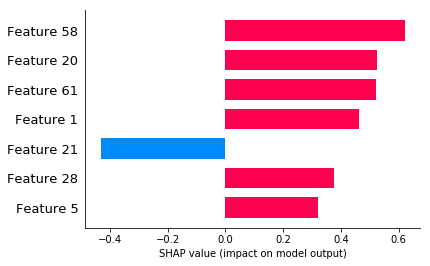

In [64]:
shap.bar_plot(explainer.shap_values(testx[2])[1])

In [37]:
testx.shape

(75, 71)

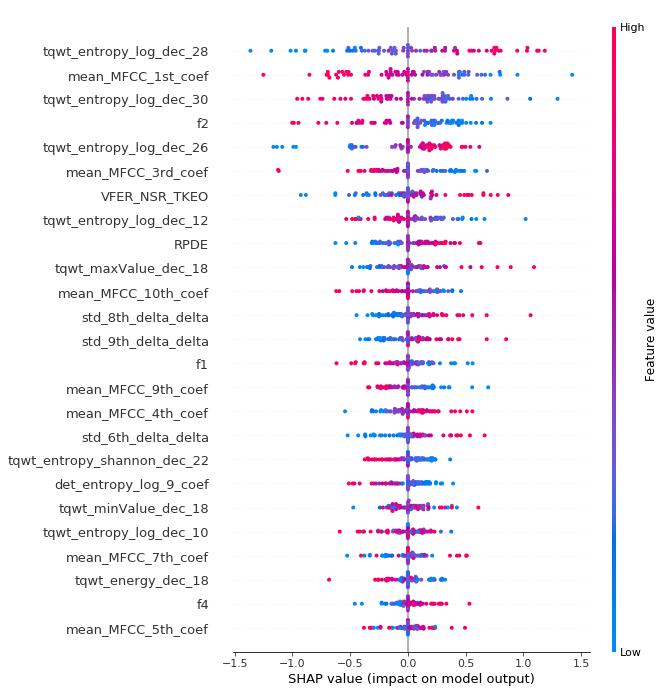

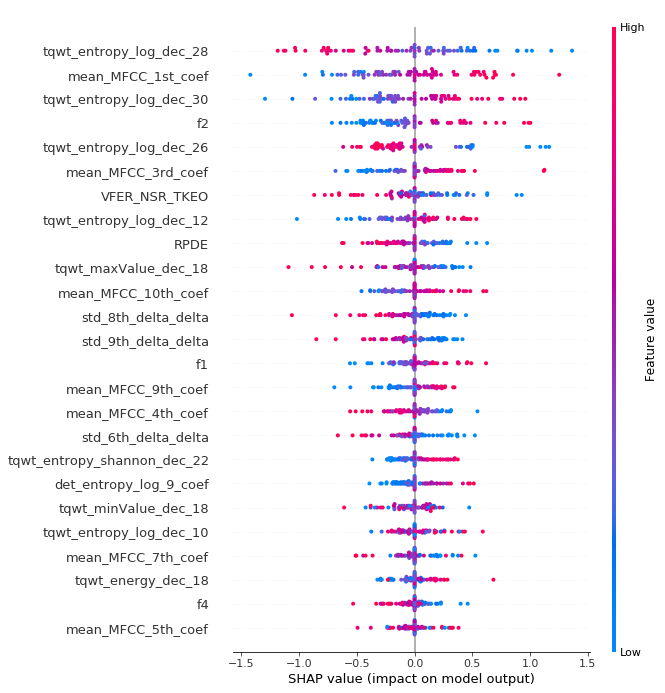

In [54]:
shap.summary_plot(shap_values[1], testx,feature_names=list(df.columns), max_display=25)
shap.summary_plot(shap_values[0], testx,feature_names=list(df.columns), max_display=25)

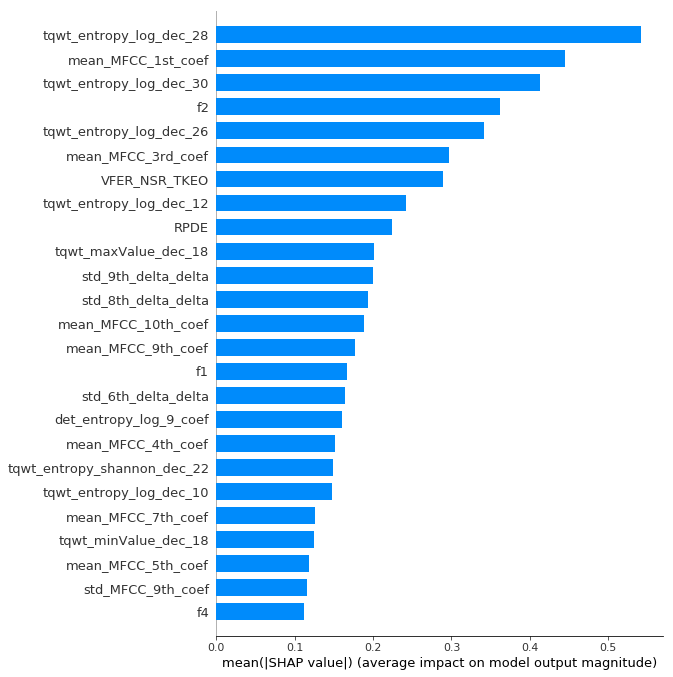

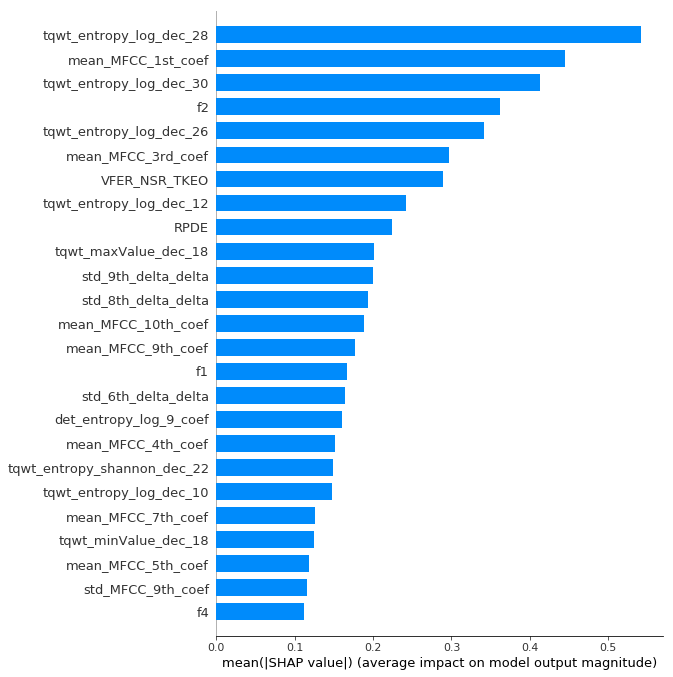

In [65]:
shap.summary_plot(shap_values[1], testx,feature_names=list(df.columns), max_display=25, plot_type='bar')
shap.summary_plot(shap_values[0], testx,feature_names=list(df.columns), max_display=25, plot_type='bar')

In [83]:
trainx=x_train[tridx,:]
trainy=y_train[tridx]
testx=x_train[tstidx,:]
testy=y_train[tstidx]

svm_=svm.SVC(C=10, gamma=0.01, probability=True, random_state=10)
svm_.fit(trainx,trainy)

testx_summary = shap.kmeans(testx, 10)
explainer = shap.KernelExplainer(svm_.decision_function, testx_summary, link='identity')
shap_values = explainer.shap_values(testx)

  0%|          | 0/75 [00:00<?, ?it/s]

In [84]:
svm_estimator

SVC(C=10, gamma=0.01, probability=True, random_state=10)

In [85]:
svm_.decision_function

<bound method BaseSVC.decision_function of SVC(C=10, gamma=0.01, probability=True, random_state=10)>

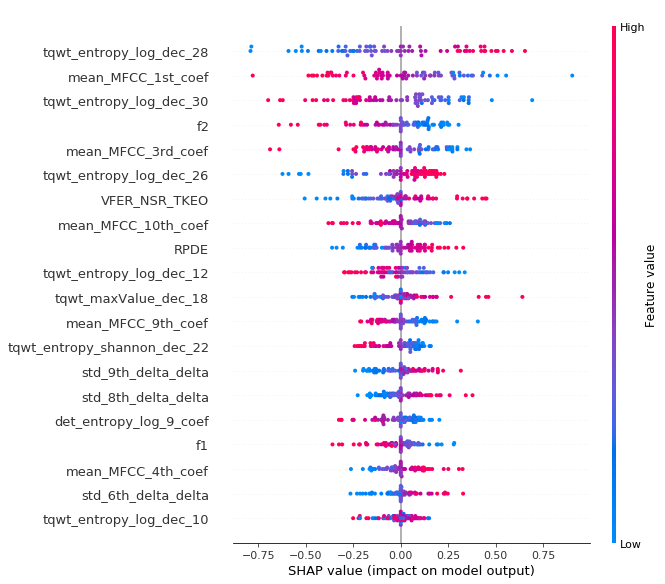

In [100]:
shap.summary_plot(shap_values, testx,feature_names=list(df.columns), max_display=20, show=False)
plt.savefig('svm_gender_top_20.png', dpi=300, bbox_inches='tight')


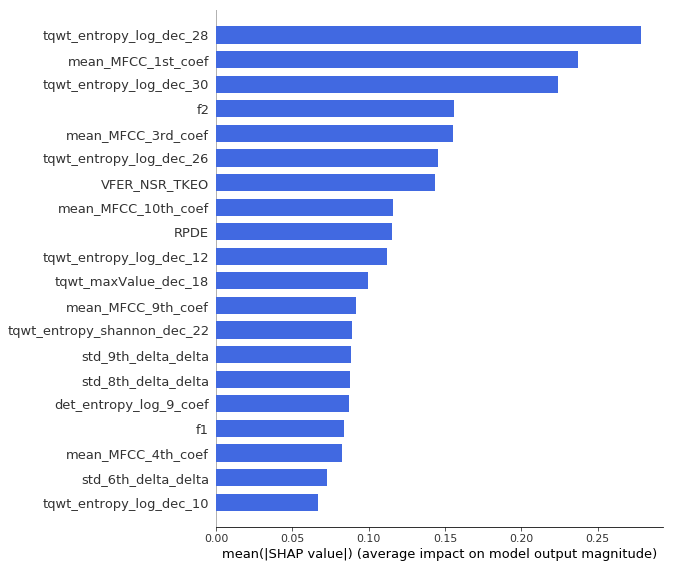

In [104]:
shap.summary_plot(shap_values, testx,feature_names=list(df.columns), max_display=20, plot_type='bar', color='royalblue', show=False)
plt.savefig('svm_gender_bar_20_features.png', dpi=300, bbox_inches='tight')

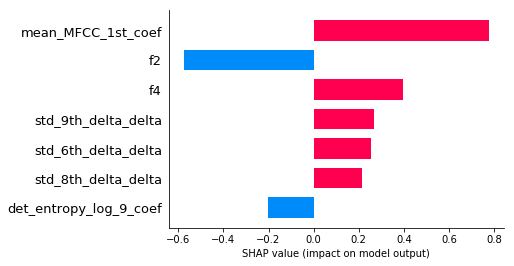

In [118]:
shap.bar_plot(explainer.shap_values(x_train[90]),feature_names=list(df.columns), show=False)
plt.savefig('data90_correct_prediction.png', dpi=300, bbox_inches='tight')

In [93]:
svm_.decision_function(testx[:20])

array([ 0.65235911,  0.47644417,  0.97043541,  0.63322936,  1.53743317,
        0.53987436,  1.6002836 ,  0.97995711,  0.04609302, -1.46673854,
        1.75555198, -0.94495447,  2.49097085,  0.71962411, -1.67932904,
       -1.3143377 , -0.67266942,  2.71313024,  0.9769639 ,  1.61698577])

In [94]:
svm_.predict(testx[:20])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 1.])